# AirBnB Seattle Data Analysis (continued)
For the Udacity Data Scientist Blog Post an analysis of dataset has to be done.
This notebook is used to analyze the data from AirBnB Seattle provided in Kaggle:

* https://www.kaggle.com/datasets/airbnb/seattle


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
%matplotlib inline

df_cal = pd.read_csv('./data/calendar.csv')
df_list = pd.read_csv('./data/listings.csv')
df_rev = pd.read_csv('./data/reviews.csv')

# Question 3 - Did customer stop using AirBnB after they gave a bad rating?

To analyze this question we could look for reviews from the same person (reviewer_id) which have a better rating at the beginning and one bad rating at the end.

Unfortunately the relevant information for analyzing this question is not in the data.

In [3]:
df_rev.head()

listing_id        id        date  reviewer_id reviewer_name  \
0     7202016  38917982  2015-07-19     28943674        Bianca   
1     7202016  39087409  2015-07-20     32440555         Frank   
2     7202016  39820030  2015-07-26     37722850           Ian   
3     7202016  40813543  2015-08-02     33671805        George   
4     7202016  41986501  2015-08-10     34959538          Ming   

                                            comments  
0  Cute and cozy place. Perfect location to every...  
1  Kelly has a great room in a very central locat...  
2  Very spacious apartment, and in a great neighb...  
3  Close to Seattle Center and all it has to offe...  
4  Kelly was a great host and very accommodating ...

The data reviews do not contain the rating.
So, this question can not be answered as originally intended.

Another aproach could be to look for the worst rated listings and look, if there are reviewers which had this listing rated as last review.

Sorting the dataframe by rating

In [14]:
df_list_worst = df_list.dropna(subset=["review_scores_rating", "id"]).sort_values("review_scores_rating")[["review_scores_rating", "id"]]
#df_list_worst = df_list.dropna(subset=["review_scores_rating"]).sort_values("review_scores_rating")["review_scores_rating"]
df_list_worst

review_scores_rating       id
1222                  20.0  9183838
3148                  40.0  5639238
2320                  40.0  8474294
1162                  40.0  9151865
1666                  40.0  9151374
...                    ...      ...
2014                 100.0  7674720
2000                 100.0  9908591
1999                 100.0  6926511
2029                 100.0  4567243
3814                 100.0  8902327

[3171 rows x 2 columns]

lets take a look at the distribution

count    3171.000000
mean       94.539262
std         6.606083
min        20.000000
25%        93.000000
50%        96.000000
75%        99.000000
max       100.000000
Name: review_scores_rating, dtype: float64

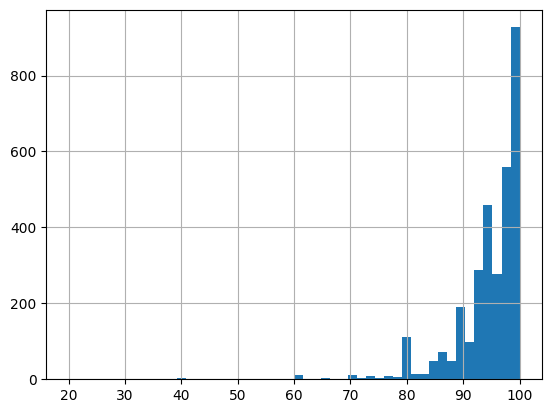

In [17]:
df_list_worst["review_scores_rating"].hist(bins=50)
df_list_worst["review_scores_rating"].describe()

There are only very few bad ratings (<50), so lets fokus on this listings.

In [18]:
df_list_worst[df_list_worst["review_scores_rating"] < 50]

review_scores_rating       id
1222                  20.0  9183838
3148                  40.0  5639238
2320                  40.0  8474294
1162                  40.0  9151865
1666                  40.0  9151374

In [67]:
df_list_worst[df_list_worst["review_scores_rating"] < 70].groupby("review_scores_rating").count()

id
review_scores_rating    
20.0                   1
40.0                   4
53.0                   1
55.0                   1
57.0                   1
60.0                  12
64.0                   1
65.0                   1
66.0                   2
67.0                   2
68.0                   2

In [21]:
worst_listing_ids = list(df_list_worst[df_list_worst["review_scores_rating"] < 50]["id"])
worst_listing_ids

[9183838, 5639238, 8474294, 9151865, 9151374]

In [48]:
bad_reviews = df_rev[df_rev["listing_id"].isin(worst_listing_ids)]
bad_reviews

listing_id        id        date  reviewer_id     reviewer_name  \
43527     9183838  55880754  2015-12-06      4822953          Svetlana   
53315     5639238  30364450  2015-04-20     15207038               Mel   
53316     5639238  30534500  2015-04-23     11921744  Jennifer & Chris   
72262     9151865  56329934  2015-12-12     21545556           Shinjae   
78872     9151374  53543652  2015-11-09     24212341              Mike   
78873     9151374  54081493  2015-11-15     27128862            Marlon   
78874     9151374  54967522  2015-11-26     15025695             Diane   
80851     8474294  51219173  2015-10-18        44631          Bradford   

                                                comments  
43527  Unfortunately my experience with the Belltown ...  
53315  Tim was very responsive and clear in his instr...  
53316  Tim was a good host and was very responsive to...  
72262  I stayed at Vivian's place since it was locate...  
78872  TL;DR - This place has a ton of potential, but...  
78873  The host canceled this reservation the day bef...  
78874  The host canceled this reservation the day bef...  
80851  A beautiful, clean house in a convenient locat...

This is an overseeable number of reviews (8).
Of course, this is only a guess, that these reviews are really bad, because the average rating of the listing was bad.
So, manually look at the comments:

In [37]:
list(bad_reviews["comments"])

["Unfortunately my experience with the Belltown apartment in Seattle is very very disappointing :(  I hate to complain or write negative reviews, however I have to do it.\r\nThe first, this apartment we booked for 3 guests. There is a king size bed for 2 people and for a third person  a very small, tiny and narrow sofa, that is good enough to have a short nap!!!!  When I called to a property management and told that... The answer was : we can deliver a air bed for 50$ delivery fee ?!?!? Why ?!? We paid for a night 319$ US. \r\nThe second one, there is NO internet ! We again, called to the property managemnet and asked if there is a wireless or wired Internet ! The man on the phone said,he would call to the owner and asked for a WIFI password and log in. Never called  us back :( \r\nThe third, it was very cold in the appartment ! There is no an instruction or a guest info book or so... \r\nWe at our own risk, opened the hitter's vents and eventually it was little bit warmer! \r\nOne mor

Manually cleansing the texts:

* 30534500 is positiv
* 54081493 was created automatically because of cancellation 
* 54967522 was created automatically because of cancellation 



In [52]:
really_bad_reviews = bad_reviews[~bad_reviews["id"].isin([30534500, 54081493, 54967522])]
really_bad_reviews

listing_id        id        date  reviewer_id reviewer_name  \
43527     9183838  55880754  2015-12-06      4822953      Svetlana   
53315     5639238  30364450  2015-04-20     15207038           Mel   
72262     9151865  56329934  2015-12-12     21545556       Shinjae   
78872     9151374  53543652  2015-11-09     24212341          Mike   
80851     8474294  51219173  2015-10-18        44631      Bradford   

                                                comments  
43527  Unfortunately my experience with the Belltown ...  
53315  Tim was very responsive and clear in his instr...  
72262  I stayed at Vivian's place since it was locate...  
78872  TL;DR - This place has a ton of potential, but...  
80851  A beautiful, clean house in a convenient locat...

In [61]:
neg_reviewerids = list(really_bad_reviews["reviewer_id"])
neg_reviewers_reviews = df_rev[df_rev["reviewer_id"].isin(neg_reviewerids)]
neg_reviewers_reviews.groupby("reviewer_id").count()

listing_id  id  date  reviewer_name  comments
reviewer_id                                               
44631                 2   2     2              2         2
4822953               1   1     1              1         1
15207038              2   2     2              2         2
21545556              2   2     2              2         2
24212341              1   1     1              1         1

The reviewers did not really write lots of reviews during this time. Only 3 reviewers wrote 2 reviews, the others wrote only the negative review

In [62]:
df_rev[df_rev["reviewer_id"] == 44631]

listing_id        id        date  reviewer_id reviewer_name  \
24150      319768   9419492  2013-12-28        44631      Bradford   
80851     8474294  51219173  2015-10-18        44631      Bradford   

                                                comments  
24150  What a COOL place! Jen was kind enough to let ...  
80851  A beautiful, clean house in a convenient locat...

In [63]:
df_rev[df_rev["reviewer_id"] == 15207038]

listing_id        id        date  reviewer_id reviewer_name  \
53315     5639238  30364450  2015-04-20     15207038           Mel   
55437     2309250  29861113  2015-04-13     15207038           Mel   

                                                comments  
53315  Tim was very responsive and clear in his instr...  
55437  Michelle and Mark were awesome from the start....

In [64]:
df_rev[df_rev["reviewer_id"] == 21545556]

listing_id        id        date  reviewer_id reviewer_name  \
21971      279063  54493807  2015-11-20     21545556       Shinjae   
72262     9151865  56329934  2015-12-12     21545556       Shinjae   

                                                comments  
21971  I had a last minute trip to seattle and calen'...  
72262  I stayed at Vivian's place since it was locate...

# Result

Based on the very small amount of extracted data (due to missing rating field in revisions) it is not possible to answer the question. Two from three reviewers wrote the bad review as last, one as first. So, even in this small data set there is no tendency to see.